In [29]:
import sys
sys.path.append("./libs/")

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import shift_data, print_hp,print_line, graficarTodo, split_df, graficarClases, plot_metrics, plot_cm, plot_roc, plot_prc, plot_probs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import datetime
import os
import keras_tuner as kt
from keras_tuner import HyperModel
import keras.metrics as metrics
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.losses import BinaryCrossentropy

# Carga de datos

In [31]:
df = pd.read_csv('./data/USA_DATA_DIFF.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 1976-12-01 to 2022-11-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INDPRO     552 non-null    float64
 1   PAYEMS     552 non-null    float64
 2   UNRATENSA  552 non-null    float64
 3   MPRIME     552 non-null    float64
 4   TOTALSA    552 non-null    float64
 5   Class      552 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 30.2 KB


In [33]:
df.describe()

,INDPRO,PAYEMS,UNRATENSA,MPRIME,TOTALSA,Class
count,552.000000,552.000000,552.000000,552.000000,5.520000e+02,552.000000
mean,0.001504,0.001188,0.001758,-0.000092,-6.503275e-07,0.115942
std,0.003272,0.001763,0.017313,0.018738,8.059840e-03,0.320446
min,-0.012309,-0.006452,-0.096487,-0.051722,-3.474568e-02,0.000000
25%,0.000322,0.000509,-0.003765,-0.009446,-3.181993e-03,0.000000
50%,0.002075,0.001442,0.005265,0.000082,7.457537e-04,0.000000
75%,0.003471,0.002111,0.009246,0.013065,5.037476e-03,0.000000
max,0.008630,0.004349,0.054615,0.048879,1.919342e-02,1.000000


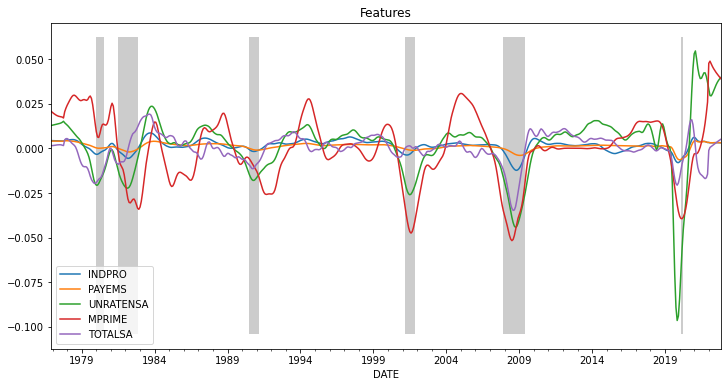

In [34]:
graficarTodo(df,'Features')

# Dividir Datos

In [35]:
target_col = ['Class']
features = df.columns[(df.columns!=target_col[0])]
df_train, df_test = split_df(df,0.2)

# Normalizar

In [36]:
df_x_train = df_train[features].copy()
df_y_train = df_train[target_col].copy()
df_x_test = df_test[features].copy()
df_y_test = df_test[target_col].copy()

scaler = StandardScaler()

df_x_train.iloc[:,:] = scaler.fit_transform(df_x_train)
df_x_test.iloc[:,:] = scaler.transform(df_x_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-5,5)
df_x_test.iloc[:,:] = np.clip(df_x_test,-5,5)

# Construccion

In [37]:
n_features = len(features)

In [38]:
res_eeuu_1 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_1_20221231_0011_2.h5', 16],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_1_20221230_2048_18.h5', 7],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_1_20221230_1841_0.h5', 6],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_1_20221230_1945_0.h5', 6],
}
res_eeuu_6 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_6_20221231_0011_5.h5', 15],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_6_20221230_2048_5.h5', 15],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_6_20221230_1841_12.h5', 6],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_6_20221230_1945_18.h5', 5],
}
res_eeuu_12 = {
    'MLP_EEUU':['./modelamiento/modelos/MLP_USA_12_20221231_0011_6.h5', 13],
    'CNN_EEUU':['./modelamiento/modelos/CNN_USA_12_20221230_2048_15.h5', 23],
    'LSTM_EEUU':['./modelamiento/modelos/LSTM_USA_12_20221230_1841_16.h5', 6],
    'GRU_EEUU':['./modelamiento/modelos/GRU_USA_12_20221230_1945_19.h5', 7],
}

# Evaluar

In [39]:
def predecir(models: dict, n_steps_out):
    df_res = df_y_test.copy()
    df_res = df_res.shift(-n_steps_out)
    df_val = pd.DataFrame()

    for key in models.keys():
        n_steps_in = models[key][1]
        model = load_model(models[key][0])
        #x_train, y_train = shift_data(df_x_train, df_y_train, n_steps_in, n_steps_out)
        x_test, y_test, indexes = shift_data(df_x_test, df_y_test, n_steps_in, n_steps_out)
        y_pred = model(x_test)
        df = pd.DataFrame()
        df['DATE'] = indexes
        df['DATE'] = pd.to_datetime(df['DATE'])
        df[key] = y_pred
        df = df.set_index('DATE')
        df_res = pd.concat([df_res, df[key]], axis=1)
    
        res = model.evaluate(x_test, y_test, verbose=0)
        df_val_n = pd.DataFrame({
            'tp': [res[1]],
            'fp': [res[2]],
            'tn': [res[3]],
            'fn': [res[4]],
            'accuracy': [res[5]],
            'precision': [res[6]],
            'recall': [res[7]],
            'auc': [res[8]],
            'prc': [res[9]],
        }, index = [key])
        df_val = pd.concat([df_val, df_val_n])

    return df_res, df_val

In [44]:
df_1, df_1_val = predecir(res_eeuu_1,1)
#graficarTodo(df_1,"Predicción de Recesión con 1 mes de anticipación")
df_1_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,3.0,11.0,80.0,0.0,0.882979,0.214286,1.0,0.961538,0.300000
CNN_EEUU,3.0,14.0,86.0,0.0,0.864078,0.176471,1.0,0.980000,0.428571
LSTM_EEUU,3.0,13.0,88.0,0.0,0.875000,0.187500,1.0,0.990099,0.600000
GRU_EEUU,3.0,11.0,90.0,0.0,0.894231,0.214286,1.0,0.980198,0.428571


In [41]:
df_6,df_6_val = predecir(res_eeuu_6,6)
#graficarTodo(df_6,"Predicción de Recesión con 6 meses de anticipación")
df_6_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,3.0,10.0,77.0,0.0,0.888889,0.230769,1.0,0.971264,0.375000
CNN_EEUU,3.0,9.0,78.0,0.0,0.900000,0.250000,1.0,0.977012,0.428571
LSTM_EEUU,3.0,22.0,74.0,0.0,0.777778,0.120000,1.0,0.961806,0.280190
GRU_EEUU,3.0,9.0,88.0,0.0,0.910000,0.250000,1.0,0.994845,0.828990


In [42]:
df_12, df_12_val = predecir(res_eeuu_12,12)
#graficarTodo(df_12,"Predicción de Recesión con 12 meses de anticipación")
df_12_val

,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
MLP_EEUU,3.0,23.0,60.0,0.0,0.732558,0.115385,1.000000,0.891566,0.136954
CNN_EEUU,2.0,26.0,47.0,1.0,0.644737,0.071429,0.666667,0.780822,0.082133
LSTM_EEUU,0.0,8.0,82.0,3.0,0.881720,0.000000,0.000000,0.475926,0.029402
GRU_EEUU,3.0,37.0,52.0,0.0,0.597826,0.075000,1.000000,0.698502,0.048641
